In [1]:
import torch 
from torch.utils.data import Dataset
from dataclasses import dataclass
import matplotlib.pyplot as plt
import fastjet as fj
import h5py
import pandas as pd
import numpy as np

# LHC Olympics: cluster jets

In [2]:
def get_constituents(jet, relative_coords=True, max_particles=100):
    pt = jet.pt()
    eta = jet.eta()
    phi = jet.phi()
    constituents = []
    N = len(jet.constituents())
        
    for c in jet.constituents():
        feats = [c.pt() / pt, eta - c.eta(), phi - c.phi(), 1] if relative_coords else [c.pt(), c.eta(), c.phi(), 1]
        constituents += [feats]

    constituents = np.array(constituents)
    constituents = constituents[constituents[:,0].argsort()[::-1]]
    assert N <= max_particles, "Number of particles in jet is greater than max_particles"
    constituents = np.pad(constituents, ((0, max_particles - N), (0,0)), 'constant')

    return constituents


def get_dijet_datasets(file, stop=None, jet_algorithm='antikt', R=1.0, pt_jet_min=20.0, max_particles=280):

    data = pd.read_hdf(file,  stop=stop).to_numpy()
    events = data[..., :-1].reshape(data.shape[0], 700, -1)
    labels = data[..., -1]
    dijet_features = []
    particle_features = []

    for event in events:
        event = event[event[:,0] != 0]
        pseudojets = []
        
        for particle in event:
            pj = fj.PseudoJet()
            pj.reset_PtYPhiM(particle[0], particle[1], particle[2], 0.0)
            pseudojets.append(pj)

        if jet_algorithm=='antikt': algorithm = fj.antikt_algorithm
        elif jet_algorithm=='cambridge': algorithm = fj.cambridge_algorithm
        elif jet_algorithm=='kt': algorithm = fj.kt_algorithm

        jet_def = fj.JetDefinition(algorithm, R)
        jets = jet_def(pseudojets)
        jets = [j for j in jets if j.pt() > pt_jet_min]

        if len(jets)>=2:
            j0, j1 = jets[0], jets[1]
            dijet_features.append([(j0 + j1).m(), j0.delta_R(j1), 
                                   j0.pt(), j0.eta(), j0.phi(), j0.m(), len(j0.constituents()),
                                   j1.pt(), j1.eta(), j1.phi(), j1.m(), len(j1.constituents())])
            consitutents_1 = get_constituents(j0, max_particles=max_particles)
            consitutents_2 = get_constituents(j1, max_particles=max_particles)
            particle_features.append(np.concatenate([consitutents_1, consitutents_2], axis=-1))
        
    dijet_features = np.array(dijet_features)
    dijet_features = np.concatenate([labels[:, None], dijet_features], axis=-1)
    particle_features = np.array(particle_features)

    # save jets:
    with h5py.File('../data/LHCOlympics2020/events_anomalydetection_dijets.h5', 'w') as f:
        f.create_dataset('dijet features', data=dijet_features)
        f.create_dataset('particle features', data=particle_features)


In [3]:
get_dijet_datasets(file='../data/LHCOlympics2020/events_anomalydetection.h5', 
                   stop=500000, 
                   jet_algorithm='antikt', 
                   R=1.0, 
                   pt_jet_min=20.0, 
                   max_particles=275)

#--------------------------------------------------------------------------
#                         FastJet release 3.4.1
#                 M. Cacciari, G.P. Salam and G. Soyez                  
#     A software package for jet finding and analysis at colliders      
#                           http://fastjet.fr                           
#	                                                                      
# Please cite EPJC72(2012)1896 [arXiv:1111.6097] if you use this package
# for scientific work and optionally PLB641(2006)57 [hep-ph/0512210].   
#                                                                       
# FastJet is provided without warranty under the GNU GPL v2 or higher.  
# It uses T. Chan's closest pair algorithm, S. Fortune's Voronoi code,
# CGAL and 3rd party plugin jet algorithms. See COPYING file for details.
#--------------------------------------------------------------------------


### get jets from h5 file

In [4]:
file = '../data/LHCOlympics2020/events_anomalydetection_dijets.h5'
f = h5py.File(file, 'r') 
dijets = f['dijet features']
particles = f['particle features']

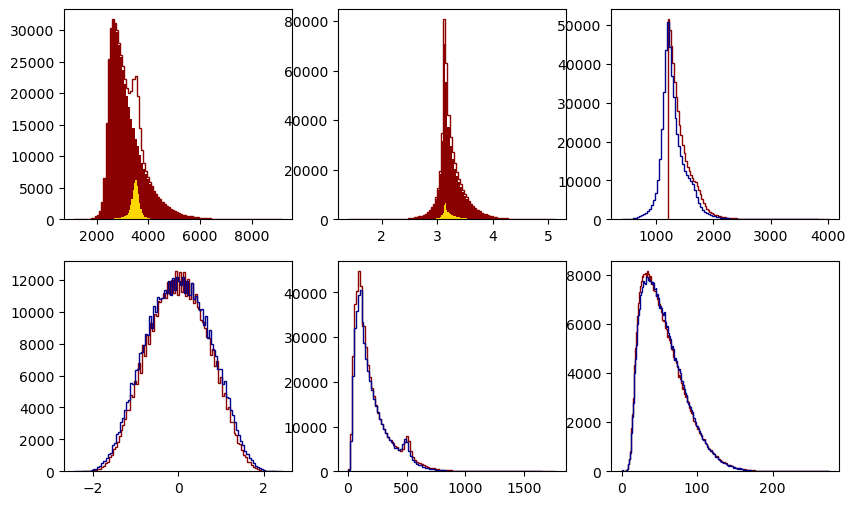

In [5]:
fig, axs = plt.subplots(2, 3, figsize=(10, 6))
axs[0, 0].hist(dijets[...,1], bins=100, histtype='step', color='darkred')
axs[0, 0].hist(dijets[...,1][dijets[...,0]==0], bins=100, histtype='stepfilled', color='darkred')
axs[0, 0].hist(dijets[...,1][dijets[...,0]==1], bins=100, histtype='stepfilled', color='gold')
axs[0, 1].hist(dijets[...,2], bins=100, histtype='step', color='darkred')
axs[0, 1].hist(dijets[...,2][dijets[...,0]==0], bins=100, histtype='stepfilled', color='darkred')
axs[0, 1].hist(dijets[...,2][dijets[...,0]==1], bins=100, histtype='stepfilled', color='gold')
axs[0, 2].hist(dijets[...,3], bins=100, histtype='step', color='darkred')
axs[0, 2].hist(dijets[...,8], bins=100, histtype='step', color='darkblue')
axs[1, 0].hist(dijets[...,4], bins=100, histtype='step', color='darkred')
axs[1, 0].hist(dijets[...,9], bins=100, histtype='step', color='darkblue')
axs[1, 1].hist(dijets[...,6], bins=100, histtype='step', color='darkred')
axs[1, 1].hist(dijets[...,11], bins=100, histtype='step', color='darkblue')
axs[1, 2].hist(dijets[...,7], bins=range(275), histtype='step', color='darkred')
axs[1, 2].hist(dijets[...,12], bins=range(275), histtype='step', color='darkblue')
plt.show()

# Datasets

In [92]:
class LHCOlympicsDataset(Dataset):

    def __init__(self, preprocess=None):
        
        self.preprocess_methods = preprocess
        self.num_samples = 60000
        self.sideband_1 = {'mjj': [2700, 3100]}
        self.sideband_2 = {'mjj': [3900, 13000]}
        
        self.signal_region = {'mjj': [self.sideband_1['mjj'][1], self.sideband_2['mjj'][0]]}
        self.summary_stats = None
    
        ''' data attributes:
            - target: jetnet data
            - target_preprocessed:  jetnet data with preprocessing
            - source: std gaussian noise
        '''

        self.get_target_data()
        self.get_source_data()
        self.get_background_data()

    def __getitem__(self, idx):
        output = {}
        output['target'] = self.target_preprocess[idx]
        output['source'] = self.source_preprocess[idx]
        output['mask'] = torch.ones_like(self.target[idx][..., 0])
        output['context'] = torch.empty_like(self.target[idx][..., 0])
        return output


    def __len__(self):
        return self.dijets.size(0)
    
    def __iter__(self):
        for i in range(len(self)):
            yield self[i]

    def get_target_data(self):
        file = '../data/LHCOlympics2020/events_anomalydetection_dijets.h5'
        f = h5py.File(file, 'r') 
        dijets = torch.Tensor(f['dijet features'])
        sb2 = PreProcessLHCOlympicsData(dijets,  num_samples=self.num_samples, cuts=self.sideband_2, methods=self.preprocess_methods)
        sb2.apply_cuts()
        self.target = sb2.features.clone()
        self.target_context = sb2.log_mjj.clone()
        sb2.preprocess()
        self.target_summary_stats = sb2.summary_stats
        self.target_preprocess = sb2.features.clone()
        f.close()

    def get_source_data(self):
        file = '../data/LHCOlympics2020/events_anomalydetection_dijets.h5'
        f = h5py.File(file, 'r') 
        dijets = torch.Tensor(f['dijet features'])
        sb1 = PreProcessLHCOlympicsData(dijets, num_samples=self.num_samples, cuts=self.sideband_1, methods=self.preprocess_methods)
        sb1.apply_cuts()
        self.source = sb1.features.clone()
        self.source_context = sb1.log_mjj.clone()
        sb1.preprocess()
        self.source_summary_stats = sb1.summary_stats
        self.source_preprocess = sb1.features.clone()
        f.close()

    def get_background_data(self):
        file = '../data/LHCOlympics2020/events_anomalydetection_dijets.h5'
        f = h5py.File(file, 'r') 
        dijets = torch.Tensor(f['dijet features'])
        sr = PreProcessLHCOlympicsData(dijets, num_samples=self.num_samples, cuts=self.signal_region, methods=self.preprocess_methods)
        sr.apply_cuts(background=True)
        self.background = sr.features.clone()
        self.background_context = sr.log_mjj.clone()
        sr.preprocess()
        self.background_summary_stats = sr.summary_stats
        self.background_preprocess = sr.features.clone()
        f.close()


class PreProcessLHCOlympicsData:

    def __init__(self, 
                 data, 
                 num_samples: int=None,
                 cuts: dict={'mjj': None},
                 methods: list=None
                 ):
        
        self.features = data
        self.cuts = cuts 
        self.num_samples = num_samples
        self.methods = methods
        self.summary_stats = {}

    def apply_cuts(self, background=False):
        self.selection_cuts(feature='mjj', cut=self.cuts['mjj'], background=background)

    def preprocess(self):        
        if self.methods is not None:
            for method in self.methods:
                method = getattr(self, method, None)
                if method and callable(method): method()
                else: raise ValueError('Preprocessing method {} not implemented'.format(method))
        else: pass
    
    def selection_cuts(self, feature, cut=None, background=False):
        if cut is None: cut=[-np.inf, np.inf]
        dic={'mjj':1}
        if background:
            self.features = self.features[self.features[...,0]==0]
        mask = (self.features[..., dic[feature]] >= cut[0]) & (self.features[..., dic[feature]] <= cut[1])
        self.features = self.features[mask]
        self.features = self.features[:self.num_samples]
        self.log_mjj = torch.log(self.features[..., 1])
        self.features = torch.cat([self.features[..., 3:7], self.features[..., 8:12]], dim=-1)  
        
    def log_pt(self):
        self.features[..., 0] = torch.log(self.features[..., 0])
        self.features[..., 4] = torch.log(self.features[..., 4])

    def log_mass(self):
        self.features[..., 3] = torch.log(self.features[..., 3]) + 2e-5
        self.features[..., 7] = torch.log(self.features[..., 7]) + 2e-5


lhco = LHCOlympicsDataset(preprocess=['log_pt', 'log_mass'])
lhco.source.shape, lhco.background.shape, lhco.target.shape, lhco.source_context.shape, lhco.background_context.shape, lhco.target_context.shape

(torch.Size([60000, 8]),
 torch.Size([60000, 8]),
 torch.Size([60000, 8]),
 torch.Size([60000]),
 torch.Size([60000]),
 torch.Size([60000]))

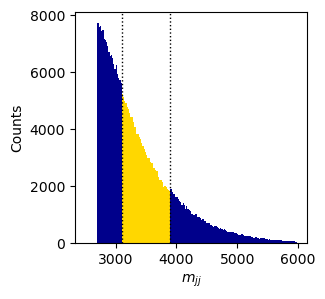

In [50]:
fig, axs = plt.subplots(1, 1, figsize=(3, 3))
_ = axs.hist(torch.exp(lhco.source_context), bins=np.arange(2500,6000, 20), histtype='stepfilled', color='darkblue')
_ = axs.hist(torch.exp(lhco.target_context), bins=np.arange(2500,6000, 20), histtype='stepfilled', color='darkblue')
_ = axs.hist(torch.exp(lhco.background_context), bins=np.arange(2500,6000, 20), histtype='stepfilled', color='gold')
#vertical line
_ = axs.axvline(x=3100, color='black', linestyle=':', lw=1)
_ = axs.axvline(x=3900, color='black', linestyle=':', lw=1)
_ = axs.set_xlabel(r'$m_{jj}$')
_ = axs.set_ylabel('Counts')

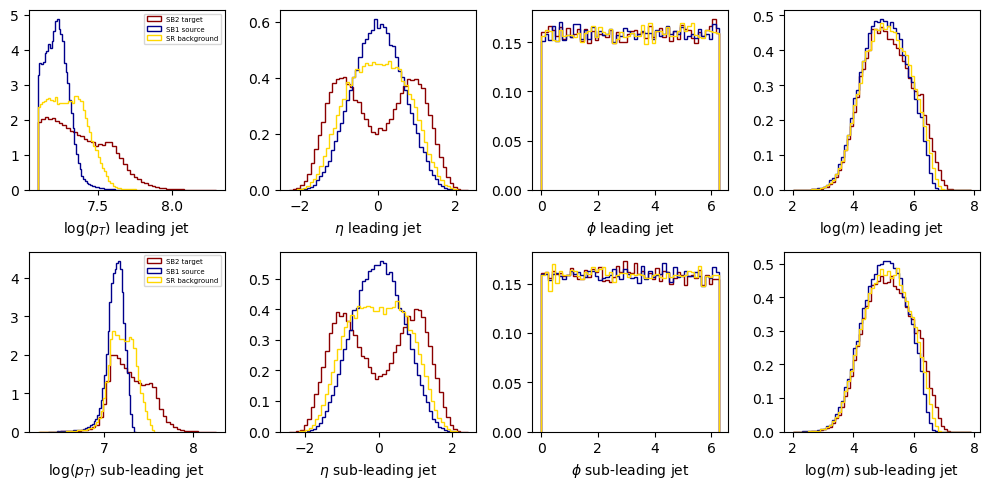

In [101]:
fig, axs = plt.subplots(2, 4, figsize=(10, 5))
axs[0,0].hist(lhco.target_preprocess[...,0], bins=50, histtype='step', color='darkred', density=True, label='SB2 target')
axs[0,0].hist(lhco.source_preprocess[...,0], bins=50, histtype='step', color='darkblue', density=True, label='SB1 source')
axs[0,0].hist(lhco.background_preprocess[...,0], bins=50, histtype='step', color='gold', density=True, label='SR background')
axs[0,0].set_xlabel(r'$\log(p_T)$ leading jet')
axs[0,0].legend(fontsize=5, loc='upper right')
axs[0,1].hist(lhco.target_preprocess[...,1], bins=50, histtype='step', color='darkred', density=True)
axs[0,1].hist(lhco.source_preprocess[...,1], bins=50, histtype='step', color='darkblue', density=True)
axs[0,1].hist(lhco.background_preprocess[...,1], bins=50, histtype='step', color='gold', density=True)
axs[0,1].set_xlabel(r'$\eta$ leading jet')
axs[0,2].hist(lhco.target_preprocess[...,2], bins=50, histtype='step', color='darkred', density=True)
axs[0,2].hist(lhco.source_preprocess[...,2], bins=50, histtype='step', color='darkblue', density=True)
axs[0,2].hist(lhco.background_preprocess[...,2], bins=50, histtype='step', color='gold', density=True)
axs[0,2].set_xlabel(r'$\phi$ leading jet')
axs[0,3].hist(lhco.target_preprocess[...,3], bins=np.arange(2,8,0.1), histtype='step', color='darkred', density=True)
axs[0,3].hist(lhco.source_preprocess[...,3], bins=np.arange(2,8,0.1), histtype='step', color='darkblue', density=True)
axs[0,3].hist(lhco.background_preprocess[...,3], bins=np.arange(2,8,0.1), histtype='step', color='gold', density=True)
axs[0,3].set_xlabel(r'$\log(m)$ leading jet')

axs[1,0].hist(lhco.target_preprocess[...,4], bins=50, histtype='step', color='darkred', density=True, label='SB2 target')
axs[1,0].hist(lhco.source_preprocess[...,4], bins=50, histtype='step', color='darkblue', density=True, label='SB1 source')
axs[1,0].hist(lhco.background_preprocess[...,4], bins=50, histtype='step', color='gold', density=True, label='SR background')
axs[1,0].set_xlabel(r'$\log(p_T)$ sub-leading jet')
axs[1,0].legend(fontsize=5, loc='upper right')
axs[1,1].hist(lhco.target_preprocess[...,5], bins=50, histtype='step', color='darkred', density=True)
axs[1,1].hist(lhco.source_preprocess[...,5], bins=50, histtype='step', color='darkblue', density=True)
axs[1,1].hist(lhco.background_preprocess[...,5], bins=50, histtype='step', color='gold', density=True)
axs[1,1].set_xlabel(r'$\eta$ sub-leading jet')
axs[1,2].hist(lhco.target_preprocess[...,6], bins=50, histtype='step', color='darkred', density=True)
axs[1,2].hist(lhco.source_preprocess[...,6], bins=50, histtype='step', color='darkblue', density=True)
axs[1,2].hist(lhco.background_preprocess[...,6], bins=50, histtype='step', color='gold', density=True)
axs[1,2].set_xlabel(r'$\phi$ sub-leading jet')
axs[1,3].hist(lhco.target_preprocess[...,7], bins=np.arange(2,8,0.1), histtype='step', color='darkred', density=True)
axs[1,3].hist(lhco.source_preprocess[...,7], bins=np.arange(2,8,0.1), histtype='step', color='darkblue', density=True)
axs[1,3].hist(lhco.background_preprocess[...,7], bins=np.arange(2,8,0.1), histtype='step', color='gold', density=True)
axs[1,3].set_xlabel(r'$\log(m)$ sub-leading jet')
plt.tight_layout()
plt.show()

array([[ 7.4993086 ,  0.89457357,  3.2527986 ,  4.6933713 ],
       [ 7.4659457 , -0.5127786 ,  0.65666884,  6.3528223 ],
       [ 7.1054063 , -1.5634587 ,  1.5192167 ,  5.4993577 ],
       ...,
       [ 7.177462  , -0.27018002,  1.9708985 ,  4.4023004 ],
       [ 7.741623  ,  0.37253097,  3.1753469 ,  5.018727  ],
       [ 7.1106524 , -1.1885105 ,  5.6072326 ,  5.1007195 ]],
      dtype=float32)